#  Import Libraries

In [1]:
import pandas as pd
import numpy as np
from feature_engine.creation import CyclicalFeatures
from feature_engine.encoding import OneHotEncoder
from transformers import BertTokenizer
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt 
import pickle
import os

#  Set constants

In [2]:
file_path = "610_ps4_test\\610_ps4_test\\testingT1FD\\cct_test.csv"
model_path = "models\\t1"
random_seed = 42

# Reading Data

In [3]:
data = pd.read_csv(file_path, header=0)

# Preprocess data

 ## Delete unwanted columns

In [4]:
def del_col(df):
    return df.drop(columns=['ssn','cc_num','unix_time','trans_num'])

## Feature Creation

 ### Combine first and last to find name

In [5]:
def get_name(df):
    df['name'] = df['first'].astype('str') + ' ' + df['last'].astype('str')
    df = df.drop(columns=['first', 'last'])
    return df

### Get distance between the two (lat,long) pairs

In [6]:
def distance_haversine(df):
    r = 6371 # distance in KM
    p = np.pi/180
    a = 0.5 - np.cos((df['merch_lat']-df['lat'])*p)/2 + np.cos(df['lat']*p) * np.cos(df['merch_lat']*p) * (1-np.cos((df['merch_long']-df['long'])*p))/2
    df['distance'] =  2 * r * np.arcsin(np.sqrt(a))
    df = df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'])
    return df
    

## Deal with Categorical data

In [7]:
ohe_cols = ['gender', 'state', 'profile', 'category']
def ohe(df):
    # load encoder
    ohe_encoder = pickle.load(open(os.path.join(model_path, 'ohe_encoder.pkl'), 'rb'))
    
    # transform df
    return ohe_encoder.transform(df)

## Deal with DateTime Data

### Convert into appropriate formats

In [8]:
def split_datetime(df):
    df[['dob_year', 'dob_month', 'dob_day']] = df['dob'].str.split('-', expand=True)
    df[['trans_date_year', 'trans_date_month', 'trans_date_day']] = df['trans_date'].str.split('-', expand=True)
    df[['trans_time_hrs', 'trans_time_mins', 'trans_time_secs']] = df['trans_time'].str.split(':', expand=True)
    df = df.drop(columns=['dob', 'trans_date', 'trans_time'])
    return df

### Decompose variables into sin and cosine components

In [9]:
# define varaible to convert and respective possible max values
cyclical_variables = ['dob_month', 'dob_day', 'trans_date_month', 'trans_date_day', 'trans_time_mins', 'trans_time_secs', 'trans_time_hrs']
max_values = {'dob_month':12, 'dob_day':31, 'trans_date_month':12, 'trans_date_day':31,'trans_time_hrs':24, 'trans_time_mins':60, 'trans_time_secs':60}


def cyclic_transform(df):
    # convert columns to numeric format
    df[cyclical_variables] = df[cyclical_variables].astype(float)

    # load encoder
    cyclical = pickle.load(open(os.path.join(model_path, 'cyclical.pkl'), 'rb'))
    
    # transform df
    return cyclical.transform(df)

## Deal with Text Data

### Preprocess data

In [10]:
def preprocess_text(text):
    # remove unnecessary characters
    text = text.replace('fraud_','').replace(',', '').replace('.', '')
    # lowercase text
    text = str(text).lower()
    return text

def preprocess_text_in_df(df):
    
    df['name'] = np.vectorize(preprocess_text)(df['name']) 
    df['job'] = np.vectorize(preprocess_text)(df['job']) 
    df['street'] = np.vectorize(preprocess_text)(df['street']) 
    df['merchant'] = np.vectorize(preprocess_text)(df['merchant']) 
    df['city'] = np.vectorize(preprocess_text)(df['city']) 
    return df

### Tokenize text data using BertTokenizer

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def find_ids(text, max_len):
    tk = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))
    for x in range(len(tk), max_len):
        tk.append(0)
    
    return tk[:max_len]

def sent_to_ids(df):
    df['name'] = df['name'].apply(find_ids, max_len=5)
    df['job'] = df['job'].apply(find_ids, max_len=10)
    df['street'] = df['street'].apply(find_ids, max_len=15)
    df['merchant'] = df['merchant'].apply(find_ids, max_len=10)
    df['city'] = df['city'].apply(find_ids, max_len=5)
    
    return df

def convert_list_to_cols(df, col_name):
    tdf = df[col_name].to_list()
    tdf = pd.DataFrame(tdf, columns=[str(col_name)+'_'+str(x) for x in range(len(tdf[0]))])
    df = pd.concat([df, tdf], axis=1)
    df = df.drop(columns=[col_name])
    return df

def convert_list_to_cols_multi(df):
    df = convert_list_to_cols(df, 'name')
    df = convert_list_to_cols(df, 'job')
    df = convert_list_to_cols(df, 'street')
    df = convert_list_to_cols(df, 'merchant')
    df = convert_list_to_cols(df, 'city')
    return df

## Convert everything to float and scale values

In [12]:
cols_to_be_normalized = ['zip', 'city_pop', 'amt',
                         'dob_month_sin', 'dob_day_sin', 
                         'trans_date_month_sin', 'trans_date_day_sin', 
                         'trans_time_mins_sin', 'trans_time_secs_sin', 
                         'dob_month_cos', 'dob_day_cos', 
                         'trans_date_month_cos', 'trans_date_day_cos', 
                         'trans_time_mins_cos', 'trans_time_secs_cos',
                         'trans_time_hrs_cos', 'trans_time_hrs_sin']

def scale(df):
    df = df.astype(float)
    
    # load encoder
    scaler = pickle.load(open(os.path.join(model_path, 'scaler.pkl'), 'rb'))
    
    scaled = scaler.transform(df[cols_to_be_normalized])
    df[cols_to_be_normalized] = pd.DataFrame(scaled, columns=cols_to_be_normalized)
    
    return df

## Create function to call above functions

In [13]:
def preprocess(df):
    print("     Feature Engineering steps")
    df = del_col(df)
    df = get_name(df)
    df = distance_haversine(df)
    print("     Dealing with Categorical Data")
    df = ohe(df)
    print("     Dealing with DateTime Date")
    df = split_datetime(df)
    df = cyclic_transform(df)
    print("     Dealing with Text Data")
    df = preprocess_text_in_df(df)
    df = sent_to_ids(df)
    df = convert_list_to_cols_multi(df)
    print("     Normalizing Data")
    df = scale(df)
    df = df.astype(float)
    print("     Done")
    return df

## Apply Preprocessing

In [14]:
print("Prepping Dataset")
data_pp = preprocess(data)

Prepping Dataset
     Feature Engineering steps
     Dealing with Categorical Data
     Dealing with DateTime Date
     Dealing with Text Data
     Normalizing Data
     Done


C:\Users\prtkm\anaconda3\envs\pmenv\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


# Creating XGB DMatrix

In [15]:
dmatrix = xgb.DMatrix(data_pp.drop(columns=['is_fraud']), data_pp['is_fraud'], missing=0.0)

# Get final score and export csv file

Classification report
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    174259
    Is Fraud       1.00      0.83      0.90       943

    accuracy                           1.00    175202
   macro avg       1.00      0.91      0.95    175202
weighted avg       1.00      1.00      1.00    175202


Accuracy
0.9990639376262828

Macro F1
0.9522010222444502

F1 for fraud class
0.9048723897911833



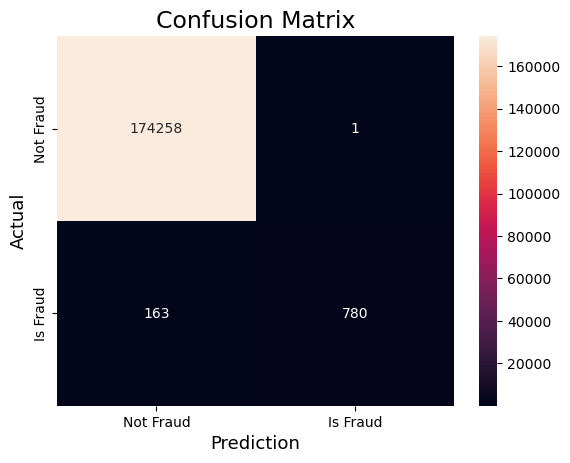

In [16]:
# load model
model = pickle.load(open(os.path.join(model_path, 'model.pkl'), 'rb'))

# get prediction
preds = model.predict(dmatrix)

# print metrics
print("Classification report")
print(classification_report(data_pp['is_fraud'], np.round(preds), labels=range(0,2), target_names=["Not Fraud", "Is Fraud"]))
print()
print("Accuracy")
print(accuracy_score(data_pp['is_fraud'], np.round(preds)))
print()
print("Macro F1")
print(f1_score(data_pp['is_fraud'], np.round(preds), average='macro'))
print()
print("F1 for fraud class")
print(f1_score(data_pp['is_fraud'], np.round(preds), average='binary'))
print()
cm = confusion_matrix(data_pp['is_fraud'],np.round(preds))
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=["Not Fraud", "Is Fraud"],
            yticklabels=["Not Fraud", "Is Fraud"])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# replace ground truth with preds
data['is_fraud'] = np.round(preds)

# export as csv
data.to_csv("Task_1_Prediction.csv", index=False)

## For baseline

Classification report


C:\Users\prtkm\anaconda3\envs\pmenv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prtkm\anaconda3\envs\pmenv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prtkm\anaconda3\envs\pmenv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   Not Fraud       0.99      1.00      1.00    174259
    Is Fraud       0.00      0.00      0.00       943

    accuracy                           0.99    175202
   macro avg       0.50      0.50      0.50    175202
weighted avg       0.99      0.99      0.99    175202


Accuracy
0.9946176413511262

Macro F1
0.4986507793430454

F1 for fraud class
0.0



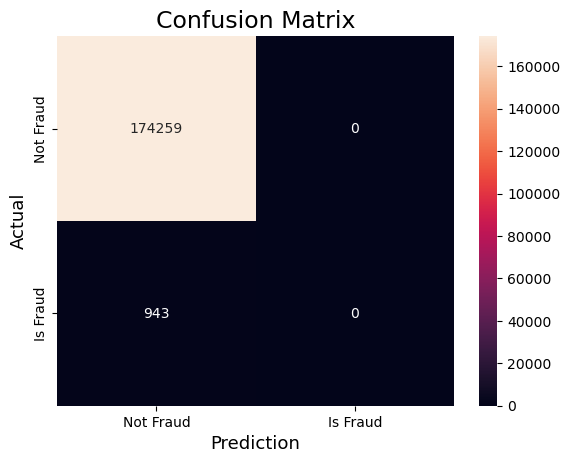

In [17]:
# get prediction
preds = [0]*len(data_pp['is_fraud'])

# print metrics
print("Classification report")
print(classification_report(data_pp['is_fraud'], np.round(preds), labels=range(0,2), target_names=["Not Fraud", "Is Fraud"]))
print()
print("Accuracy")
print(accuracy_score(data_pp['is_fraud'], np.round(preds)))
print()
print("Macro F1")
print(f1_score(data_pp['is_fraud'], np.round(preds), average='macro'))
print()
print("F1 for fraud class")
print(f1_score(data_pp['is_fraud'], np.round(preds), average='binary'))
print()
cm = confusion_matrix(data_pp['is_fraud'],np.round(preds))
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=["Not Fraud", "Is Fraud"],
            yticklabels=["Not Fraud", "Is Fraud"])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# replace ground truth with preds
data['is_fraud'] = np.round(preds)

# export as csv
data.to_csv("Task_1_Prediction_baseline.csv", index=False)